In [21]:
import torch
from einops import rearrange
import matplotlib.pyplot as plt

import sys 
sys.path.append('../')
from normalizer import RevIN, CausalRevIN, PrefixRevIN

In [22]:
dic_model_colors = {
    "Causal RevIN":          "#FF7F00",  # vivid orange
    "Causal RevIN + asinh":  "#000000",  # intense blue
    "RevIN":                 "#00CC66",  # vivid green
    "RevIN + asinh":         "#0055FF",  # electric deep blue
    "Prefix RevIN":              "#FF3300",  # bright red-orange
    "Prefix RevIN + asinh":      "#CC0099",  # strong magenta
}

dic_model_markers = {
    "Causal RevIN":          "o",   # circle
    "Causal RevIN + asinh":  "x",   # cross
    "RevIN":                 "s",   # square
    "RevIN + asinh":         "d",   # diamond
    "Prefix RevIN":              "^",   # triangle up
    "Prefix RevIN + asinh":      "v",   # triangle down
}

In [23]:
seq_len = 1024
patch_size=32

x = torch.linspace(-10, 10, seq_len).unsqueeze(0)
signal = torch.sin(x) + 0.1 * torch.randn_like(x) + x/2
patched_signal = rearrange(signal, '1 (p s) -> 1 p s', s=patch_size)

In [24]:
revin = RevIN(asinh=False)
causal_revin = CausalRevIN(asinh=False)
prefix_revin = PrefixRevIN(asinh=False)

normalized_revin = revin(patched_signal.clone(), mode='norm').flatten()
normalized_causal_revin = causal_revin(patched_signal.clone(), mode='norm').flatten()
normalized_prefix_revin = prefix_revin(patched_signal.clone(), mode='norm').flatten()

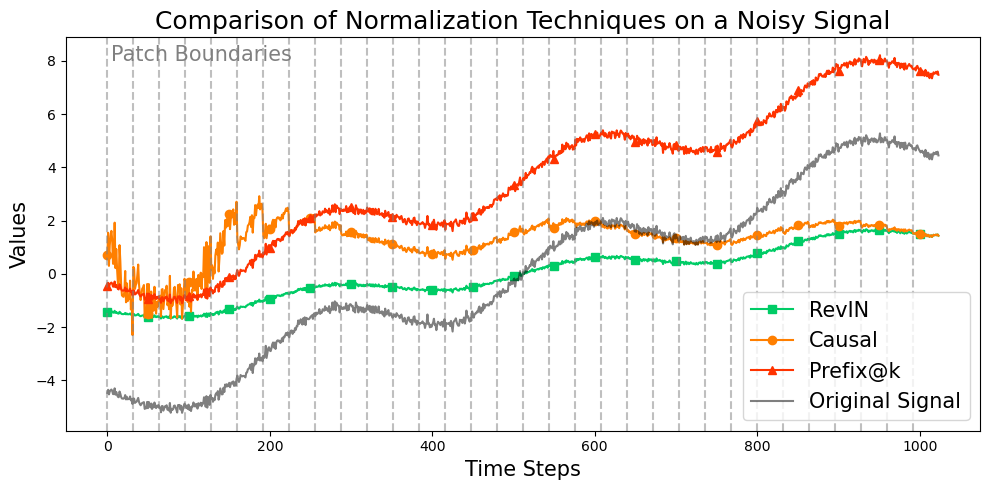

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(normalized_revin.numpy(), label='RevIN', color=dic_model_colors["RevIN"], marker=dic_model_markers["RevIN"], markevery=50)
plt.plot(normalized_causal_revin.numpy(), label='Causal', color=dic_model_colors["Causal RevIN"], marker=dic_model_markers["Causal RevIN"], markevery=50)
plt.plot(normalized_prefix_revin.numpy(), label='Prefix@k', color=dic_model_colors["Prefix RevIN"], marker=dic_model_markers["Prefix RevIN"], markevery=50)
plt.plot(signal.flatten().numpy(), label='Original Signal', alpha=0.5, color='black')
for i in range(0, seq_len, patch_size):
    plt.axvline(i, color='gray', linestyle='--', alpha=0.5)
    if i==0:
        plt.text(i+5, plt.ylim()[1]*0.9, 'Patch Boundaries', color='grey', fontsize=15)
plt.legend(fontsize=15)
plt.title('Comparison of Normalization Techniques on a Noisy Signal', fontsize=18)
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.tight_layout()
plt.savefig('figures/norm_example/causal_masking_comparison.pdf', bbox_inches='tight')

In [26]:
# during inference, the common way is to take the signal, normalize it, and denormalize it after model prediction
# however, during causal training, it is more complicated

In [27]:
errors = {'revin': [], 'causal_revin': [], 'prefix_revin': [], 'stepcausal_revin': []}
for i in range(1, 33):

    ground_truth = patched_signal[0, :i, :].flatten()
    mean = ground_truth.mean()
    std = ground_truth.std() + 1e-5
    ground_truth_normalized = (ground_truth - mean) / std

    current_revin = normalized_revin[:i*patch_size]
    current_causal_revin = normalized_causal_revin[:i*patch_size]
    if i <=7:
        current_prefix_revin = torch.nan
    else:
        current_prefix_revin = normalized_prefix_revin[:i*patch_size]
    errors['revin'].append(torch.mean((current_revin - ground_truth_normalized)**2).item())
    errors['causal_revin'].append(torch.mean((current_causal_revin - ground_truth_normalized)**2).item())
    errors['prefix_revin'].append(torch.mean((current_prefix_revin - ground_truth_normalized)**2).item())

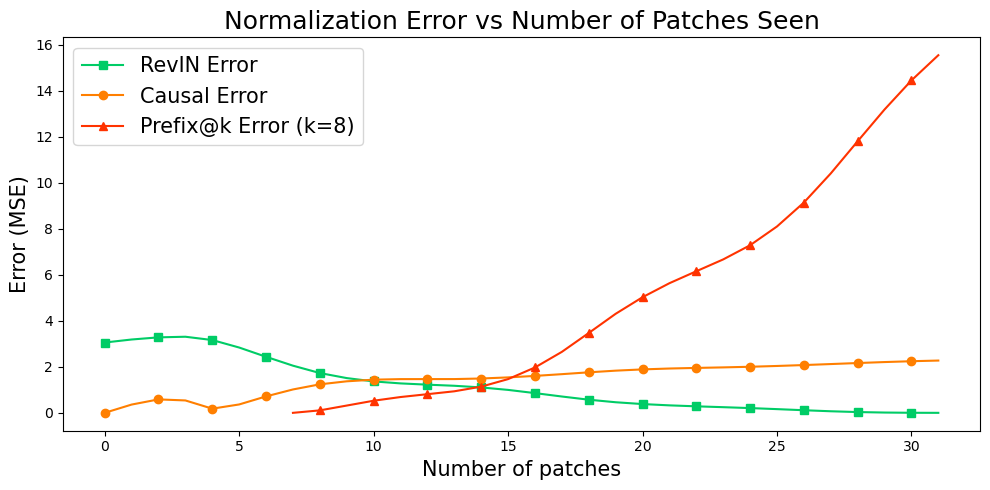

In [28]:
plt.figure(figsize=(10, 5))

plt.plot(errors['revin'], label='RevIN Error', color=dic_model_colors["RevIN"], marker=dic_model_markers["RevIN"], markevery=2)
plt.plot(errors['causal_revin'], label='Causal Error', color=dic_model_colors["Causal RevIN"], marker=dic_model_markers["Causal RevIN"], markevery=2)
plt.plot(errors['prefix_revin'], label='Prefix@k Error (k=8)', color=dic_model_colors["Prefix RevIN"], marker=dic_model_markers["Prefix RevIN"], markevery=2)
plt.legend(fontsize=15)
plt.xlabel('Number of patches', fontsize=15)
plt.ylabel('Error (MSE)', fontsize=15)
plt.title('Normalization Error vs Number of Patches Seen', fontsize=18)
plt.tight_layout()
plt.savefig('figures/norm_example/causal_masking_error.pdf', bbox_inches='tight')

In [29]:
smoothness_revin = torch.mean((normalized_revin[1:] - normalized_revin[:-1])**2)
smoothness_causal_revin = torch.mean((normalized_causal_revin[1:] - normalized_causal_revin[:-1])**2)
smoothness_prefix_revin = torch.mean((normalized_prefix_revin[1:] - normalized_prefix_revin[:-1])**2)
print(f"Smoothness RevIN: {smoothness_revin.item():.6f}")
print(f"Smoothness Causal: {smoothness_causal_revin.item():.6f}")
print(f"Smoothness Prefix@k: {smoothness_prefix_revin.item():.6f}")

Smoothness RevIN: 0.002188
Smoothness Causal: 0.098919
Smoothness Prefix@k: 0.016577
